In [ ]:
# Cell 0 — GPU check & mount Drive
import sys, os
import tensorflow as tf
print("Python", sys.version)
print("TensorFlow", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

# Mount Drive (will prompt for OAuth)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TensorFlow 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mounted at /content/drive


In [ ]:
# Cell 1 — Config & install deps
PROJECT_DIR = "/content/drive/MyDrive/AccidentProject"
DATA_RAW = os.path.join(PROJECT_DIR, "data", "raw")
FEATURE_DIR = os.path.join(PROJECT_DIR, "data", "features")
CHECKPOINT_DIR = os.path.join(PROJECT_DIR, "checkpoints")
LOG_DIR = os.path.join(PROJECT_DIR, "logs")
EXPORT_DIR = os.path.join(PROJECT_DIR, "exports", "models")
os.makedirs(DATA_RAW, exist_ok=True)
os.makedirs(FEATURE_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(EXPORT_DIR, exist_ok=True)

# Install packages if not present
!pip install -q tensorflow-addons opencv-python-headless tqdm scikit-learn

# Enable mixed precision for speed (optional but recommended)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision policy:", mixed_precision.global_policy())


ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons
Mixed precision policy: <DTypePolicy "mixed_float16">


In [ ]:
# Cell 2 — imports and small helpers
import numpy as np, cv2, glob, json, math, random, time
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
import tensorflow.keras as keras
from tensorflow.keras import layers
print("Imports ready")


Imports ready


In [ ]:
# Cell 3 — timestamp parsing and label loader (expects HH:MM:SS - HH:MM:SS per line)
def to_seconds(hms):
    hms = str(hms).strip()
    parts = [int(p) for p in hms.split(":")]
    if len(parts) == 3:
        h,m,s = parts
    elif len(parts) == 2:
        h = 0; m,s = parts
    else:
        raise ValueError("Bad timestamp: " + hms)
    return h*3600 + m*60 + s

def load_intervals(txt_path):
    intervals = []
    if not os.path.exists(txt_path):
        return intervals
    for line in open(txt_path, 'r'):
        line = line.strip()
        if not line: continue
        # handle "HH:MM:SS - HH:MM:SS" or "HH:MM:SS to HH:MM:SS"
        if "-" in line:
            a,b = line.split("-")
        elif "to" in line:
            a,b = line.split("to")
        else:
            continue
        try:
            intervals.append((to_seconds(a), to_seconds(b)))
        except:
            continue
    return intervals

def window_overlaps(start_t, end_t, intervals):
    for a,b in intervals:
        if start_t <= b and end_t >= a:
            return True
    return False


In [ ]:
# Cell 4 — CCTV-safe augmentations without imgaug (use this instead)

import numpy as np
import cv2
import random

def adjust_brightness(frame, factor):
    # factor between 0.8 and 1.2
    return np.clip(frame * factor, 0, 255).astype(np.uint8)

def adjust_contrast(frame, factor):
    # simple contrast adjustment
    mean = frame.mean(axis=(0,1), keepdims=True)
    return np.clip((frame - mean) * factor + mean, 0, 255).astype(np.uint8)

def gaussian_noise(frame, std=10):
    noise = np.random.normal(0, std, frame.shape)
    out = frame + noise
    return np.clip(out, 0, 255).astype(np.uint8)

def jpeg_compress(frame, quality=60):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, enc = cv2.imencode('.jpg', frame[:,:,::-1], encode_param)
    dec = cv2.imdecode(enc, cv2.IMREAD_COLOR)[:,:,::-1]
    return dec

def motion_blur(frame, ksize=3):
    kernel = np.zeros((ksize, ksize))
    kernel[int((ksize-1)/2), :] = 1.0 / ksize
    return cv2.filter2D(frame, -1, kernel)

def augment_frame(frame, apply_prob=0.6):
    if random.random() > apply_prob:
        return frame

    # Apply 2–4 random lightweight augmentations
    ops = []
    if random.random() < 0.7: ops.append("brightness")
    if random.random() < 0.7: ops.append("contrast")
    if random.random() < 0.4: ops.append("noise")
    if random.random() < 0.4: ops.append("blur")
    if random.random() < 0.6: ops.append("jpeg")

    random.shuffle(ops)

    f = frame.copy()
    for op in ops:
        if op == "brightness":
            f = adjust_brightness(f, random.uniform(0.8, 1.2))
        elif op == "contrast":
            f = adjust_contrast(f, random.uniform(0.8, 1.25))
        elif op == "noise":
            f = gaussian_noise(f, std=random.uniform(3, 12))
        elif op == "blur":
            f = motion_blur(f, ksize=random.choice([3,5]))
        elif op == "jpeg":
            f = jpeg_compress(f, quality=random.randint(40, 90))

    return f


In [ ]:
# Cell 5 — Feature extraction (EfficientNet-B1)
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_H = 224; IMG_W = 224
BACKBONE = EfficientNetB1(weights="imagenet", include_top=False, pooling='avg', input_shape=(IMG_H, IMG_W, 3))
BACKBONE.trainable = False
print("Backbone ready:", BACKBONE.name)

def extract_features_for_video(video_path, out_feat_path, target_fps=16, augment=False, overwrite=False):
    if os.path.exists(out_feat_path) and not overwrite:
        print("Skipping (exists):", out_feat_path)
        return
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError("Can't open video: " + video_path)
    orig_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    step = max(1, int(round(orig_fps / target_fps)))
    frames = []
    idx = 0
    while True:
        ret, f = cap.read()
        if not ret: break
        if idx % step == 0:
            f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
            f = cv2.resize(f, (IMG_W, IMG_H))
            if augment:
                f = augment_frame(f)
            frames.append(f)
        idx += 1
    cap.release()
    if len(frames) == 0:
        np.save(out_feat_path, np.zeros((0, BACKBONE.output_shape[-1]), dtype=np.float32))
        return
    batch = np.array(frames, dtype=np.float32)
    batch = preprocess_input(batch)
    # run in batches if many frames
    feat_list = []
    B = 64
    for i in range(0, len(batch), B):
        sub = batch[i:i+B]
        feats = BACKBONE.predict(sub, verbose=0)
        feat_list.append(feats)
    feats_all = np.concatenate(feat_list, axis=0)
    np.save(out_feat_path, feats_all.astype(np.float32))
    print(f"Saved features {out_feat_path} shape={feats_all.shape}")


27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Backbone ready: efficientnetb1


In [ ]:
# Cell 6 — extract features for every video in data/raw
video_files = sorted([p for p in glob.glob(os.path.join(DATA_RAW, "*")) if p.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))])
print("Found", len(video_files), "videos in", DATA_RAW)

for v in tqdm(video_files):
    base = Path(v).stem
    out = os.path.join(FEATURE_DIR, base + "-feat.npy")
    extract_features_for_video(v, out, target_fps=16, augment=False, overwrite=False)


Found 14 videos in /content/drive/MyDrive/AccidentProject/data/raw


100%|██████████| 14/14 [00:00<00:00, 2907.81it/s]

Skipping (exists): /content/drive/MyDrive/AccidentProject/data/features/1XIS9UOwC_Y-feat.npy
Skipping (exists): /content/drive/MyDrive/AccidentProject/data/features/3KSHg1inZS8-feat.npy
Skipping (exists): /content/drive/MyDrive/AccidentProject/data/features/3LsNpm5y-VA-feat.npy
Skipping (exists): /content/drive/MyDrive/AccidentProject/data/features/AuQz_-J2kzc-feat.npy
Skipping (exists): /content/drive/MyDrive/AccidentProject/data/features/Copy of BpMHNEa79lo-feat.npy
Skipping (exists): /content/drive/MyDrive/AccidentProject/data/features/Copy of L334aqEJxys-feat.npy
Skipping (exists): /content/drive/MyDrive/AccidentProject/data/features/Copy of N6zJ2inqJn0-feat.npy
Skipping (exists): /content/drive/MyDrive/AccidentProject/data/features/Copy of YzocCFJIbCc-feat.npy
Skipping (exists): /content/drive/MyDrive/AccidentProject/data/features/Copy of bCr5Grrfw4I-feat.npy
Skipping (exists): /content/drive/MyDrive/AccidentProject/data/features/Copy of hZm7dC8qBO0-feat.npy
Skipping (exists): /co

In [ ]:
# Cell 7 — Build window index files (per-video index list)
SEQ_LEN = 48
STRIDE = 8  # you can tune stride; smaller -> more samples

index_entries = []  # list of (feat_path, start_frame_idx, label)

for feat_path in tqdm(sorted(glob.glob(os.path.join(FEATURE_DIR, "*-feat.npy")))):
    base = Path(feat_path).stem.replace("-feat", "")
    # find corresponding txt in data/raw
    txt_path = None
    for ext in ('.txt', '.label'):
        cand = os.path.join(DATA_RAW, base + ext)
        if os.path.exists(cand): txt_path = cand; break
    intervals = load_intervals(txt_path) if txt_path else []
    feats = np.load(feat_path, mmap_mode='r')
    n_frames = feats.shape[0]
    if n_frames < SEQ_LEN:
        continue
    i = 0
    while i + SEQ_LEN <= n_frames:
        s_t = i / 16.0
        e_t = (i + SEQ_LEN - 1) / 16.0
        label = 1 if window_overlaps(s_t, e_t, intervals) else 0
        index_entries.append((feat_path, i, label))
        i += STRIDE

# Save index to disk (so you can reload fast)
index_file = os.path.join(PROJECT_DIR, "dataset_index.npy")
np.save(index_file, np.array(index_entries, dtype=object))
print("Total windows:", len(index_entries))


100%|██████████| 14/14 [00:28<00:00,  2.07s/it]


Total windows: 12872


In [ ]:
# Cell 8 — feature-level dataset generator (yields batches of shape [B, SEQ_LEN, feat_dim])
from sklearn.utils import resample
def feature_window_generator(index_file, batch_size=32, shuffle=True, balance=True):
    entries = list(np.load(index_file, allow_pickle=True))
    idxs = list(range(len(entries)))
    while True:
        if shuffle: random.shuffle(idxs)
        Xb, yb = [], []
        for j in idxs:
            feat_path, start_idx, label = entries[j]
            feats = np.load(feat_path, mmap_mode='r')  # memory efficient
            clip = feats[start_idx:start_idx+SEQ_LEN]  # shape (SEQ_LEN, feat_dim)
            if clip.shape[0] != SEQ_LEN:
                continue
            Xb.append(clip)
            yb.append(label)
            if len(Xb) >= batch_size:
                X = np.array(Xb, dtype=np.float32)
                y = np.array(yb, dtype=np.float32)
                if balance:
                    # simple on-batch balancing: oversample positives if needed
                    pos_idx = np.where(y==1)[0]
                    neg_idx = np.where(y==0)[0]
                    if len(pos_idx)>0 and len(pos_idx) < len(neg_idx):
                        extra = np.random.choice(pos_idx, size=(len(neg_idx)-len(pos_idx)), replace=True)
                        X = np.concatenate([X, X[extra]], axis=0)
                        y = np.concatenate([y, y[extra]], axis=0)
                perm = np.random.permutation(len(X))
                yield X[perm], y[perm]
                Xb, yb = [], []
        # flush remaining
        if len(Xb) > 0:
            X = np.array(Xb, dtype=np.float32)
            y = np.array(yb, dtype=np.float32)
            if balance:
                pos_idx = np.where(y==1)[0]
                neg_idx = np.where(y==0)[0]
                if len(pos_idx)>0 and len(pos_idx) < len(neg_idx):
                    extra = np.random.choice(pos_idx, size=(len(neg_idx)-len(pos_idx)), replace=True)
                    X = np.concatenate([X, X[extra]], axis=0)
                    y = np.concatenate([y, y[extra]], axis=0)
            perm = np.random.permutation(len(X))
            yield X[perm], y[perm]


In [ ]:
# Cell 9 — Transformer encoder on top of features
import math
def build_transformer_temporal(seq_len=SEQ_LEN, feat_dim=1280, d_model=512, n_layers=3, n_heads=8, ffn_dim=2048, dropout=0.1):
    inp = layers.Input(shape=(seq_len, feat_dim), name="feat_input")
    # Project features to d_model
    x = layers.Dense(d_model, activation=None, name="proj")(inp)
    x = layers.LayerNormalization(name="ln_in")(x)
    # Positional embeddings (learned)
    pos = layers.Embedding(input_dim=seq_len, output_dim=d_model)(tf.range(start=0, limit=seq_len, delta=1))
    x = x + pos
    # Transformer stacks (Pre-LN pattern)
    for i in range(n_layers):
        # Multi-head self-attention
        x1 = layers.LayerNormalization(name=f"ln_att_{i}")(x)
        att = layers.MultiHeadAttention(num_heads=n_heads, key_dim=d_model//n_heads, dropout=dropout, name=f"mha_{i}")(x1, x1)
        x = layers.Add()([x, att])
        # FFN
        x2 = layers.LayerNormalization(name=f"ln_ffn_{i}")(x)
        f = layers.Dense(ffn_dim, activation='relu')(x2)
        f = layers.Dropout(dropout)(f)
        f = layers.Dense(d_model)(f)
        x = layers.Add()([x, f])
    # Pooling & head
    x = layers.LayerNormalization(name="ln_out")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    # final output float32 to avoid FP16 loss issues
    out = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    model = keras.Model(inputs=inp, outputs=out, name="TemporalTransformer")
    return model

# quick build
feat_sample = np.load(sorted(glob.glob(os.path.join(FEATURE_DIR, "*-feat.npy")))[0])
feat_dim = feat_sample.shape[1]
model = build_transformer_temporal(seq_len=SEQ_LEN, feat_dim=feat_dim, d_model=512, n_layers=3, n_heads=8, ffn_dim=2048)
model.summary()


Model: "TemporalTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ feat_input          │ (None, 48, 1280)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj (Dense)        │ (None, 48, 512)   │    655,872 │ feat_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_in               │ (None, 48, 512)   │      1,024 │ proj[0][0]        │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 48, 512)   │          0 │ ln_in[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_att_0            │ (None, 48, 512)   │      1,024 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_0               │ (None, 48, 512)   │  1,050,624 │ ln_att_0[0][0],   │
│ (MultiHeadAttentio… │                   │            │ ln_att_0[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 48, 512)   │          0 │ add[0][0],        │
│                     │                   │            │ mha_0[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_ffn_0            │ (None, 48, 512)   │      1,024 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 48, 2048)  │  1,050,624 │ ln_ffn_0[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 48, 2048)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 48, 512)   │  1,049,088 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 48, 512)   │          0 │ add_1[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_att_1            │ (None, 48, 512)   │      1,024 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_1               │ (None, 48, 512)   │  1,050,624 │ ln_att_1[0][0],   │
│ (MultiHeadAttentio… │                   │            │ ln_att_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 48, 512)   │          0 │ add_2[0][0],      │
│                     │                   │            │ mha_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln_ffn_1            │ (None, 48, 512)   │      1,024 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 48, 2048)  │  1,050,624 │ ln_ffn_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 48, 2048)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 48, 512)   │  1,049,088 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 10,180,865 (38.84 MB)

 Trainable params: 10,180,865 (38.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Cell 10 — training utilities & compile (NO TFA NEEDED)

from tensorflow.keras.optimizers import AdamW

LR = 1e-4
opt = AdamW(learning_rate=LR, weight_decay=1e-4)

model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

ckpt_path = os.path.join(CHECKPOINT_DIR, "transformer_best.h5")

cb_list = [
    keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=3,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=6,
        restore_best_weights=True,
        verbose=1
    )
]


In [ ]:
# Cell 11 — Stage 1 training (transformer head only)
BATCH_SIZE = 32
STEPS_PER_EPOCH = max(10,  len(np.load(index_file, allow_pickle=True)) // BATCH_SIZE )
VAL_SPLIT = 0.1

# create generator
gen = feature_window_generator(index_file, batch_size=BATCH_SIZE, shuffle=True, balance=True)

# If you have a separate val index, use it. Here we do a quick random val split by entries.
entries = list(np.load(index_file, allow_pickle=True))
random.shuffle(entries)
n_val = int(len(entries)*VAL_SPLIT)
val_entries = entries[:n_val]
train_entries = entries[n_val:]
tmp_idx_file = os.path.join(PROJECT_DIR, "tmp_train_idx.npy")
tmp_val_idx_file = os.path.join(PROJECT_DIR, "tmp_val_idx.npy")
np.save(tmp_idx_file, np.array(train_entries, dtype=object))
np.save(tmp_val_idx_file, np.array(val_entries, dtype=object))

train_gen = feature_window_generator(tmp_idx_file, batch_size=BATCH_SIZE, shuffle=True, balance=True)
val_gen = feature_window_generator(tmp_val_idx_file, batch_size=BATCH_SIZE, shuffle=False, balance=False)

EPOCHS_STAGE1 = 30
history = model.fit(train_gen,
                    steps_per_epoch=max(10, len(train_entries)//BATCH_SIZE),
                    validation_data=val_gen,
                    validation_steps=max(1, len(val_entries)//BATCH_SIZE),
                    epochs=EPOCHS_STAGE1,
                    callbacks=cb_list)


Epoch 1/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.6643 - auc: 0.7271 - loss: 0.6213
Epoch 1: val_auc improved from -inf to 0.86350, saving model to /content/drive/MyDrive/AccidentProject/checkpoints/transformer_best.h5


362/362 ━━━━━━━━━━━━━━━━━━━━ 304s 774ms/step - accuracy: 0.6644 - auc: 0.7273 - loss: 0.6212 - val_accuracy: 0.7773 - val_auc: 0.8635 - val_loss: 0.4372 - learning_rate: 1.0000e-04
Epoch 2/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7839 - auc: 0.8555 - loss: 0.4567
Epoch 2: val_auc improved from 0.86350 to 0.91310, saving model to /content/drive/MyDrive/AccidentProject/checkpoints/transformer_best.h5


362/362 ━━━━━━━━━━━━━━━━━━━━ 101s 239ms/step - accuracy: 0.7840 - auc: 0.8556 - loss: 0.4566 - val_accuracy: 0.8359 - val_auc: 0.9131 - val_loss: 0.3351 - learning_rate: 1.0000e-04
Epoch 3/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8285 - auc: 0.9049 - loss: 0.3753
Epoch 3: val_auc improved from 0.91310 to 0.93101, saving model to /content/drive/MyDrive/AccidentProject/checkpoints/transformer_best.h5


362/362 ━━━━━━━━━━━━━━━━━━━━ 108s 299ms/step - accuracy: 0.8286 - auc: 0.9049 - loss: 0.3752 - val_accuracy: 0.8242 - val_auc: 0.9310 - val_loss: 0.3675 - learning_rate: 1.0000e-04
Epoch 4/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8693 - auc: 0.9331 - loss: 0.3141
Epoch 4: val_auc improved from 0.93101 to 0.93784, saving model to /content/drive/MyDrive/AccidentProject/checkpoints/transformer_best.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
362/362 ━━━━━━━━━━━━━━━━━━━━ 96s 267ms/step - accuracy: 0.8693 - auc: 0.9331 - loss: 0.3141 - val_accuracy: 0.8677 - val_auc: 0.9378 - val_loss: 0.2884 - learning_rate: 1.0000e-04
Epoch 5/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8955 - auc: 0.9548 - loss: 0.2534
Epoch 5: val_auc improved from 0.93784 to 0.95547, saving model to /content/drive/MyDrive/AccidentProject/checkpoints/transformer_best.h5


362/362 ━━━━━━━━━━━━━━━━━━━━ 93s 257ms/step - accuracy: 0.8955 - auc: 0.9548 - loss: 0.2534 - val_accuracy: 0.8797 - val_auc: 0.9555 - val_loss: 0.2594 - learning_rate: 5.0000e-05
Epoch 6/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9057 - auc: 0.9647 - loss: 0.2227
Epoch 6: val_auc improved from 0.95547 to 0.96049, saving model to /content/drive/MyDrive/AccidentProject/checkpoints/transformer_best.h5


362/362 ━━━━━━━━━━━━━━━━━━━━ 94s 261ms/step - accuracy: 0.9057 - auc: 0.9647 - loss: 0.2227 - val_accuracy: 0.9028 - val_auc: 0.9605 - val_loss: 0.2392 - learning_rate: 5.0000e-05
Epoch 7/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9204 - auc: 0.9743 - loss: 0.1898
Epoch 7: val_auc improved from 0.96049 to 0.96787, saving model to /content/drive/MyDrive/AccidentProject/checkpoints/transformer_best.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
362/362 ━━━━━━━━━━━━━━━━━━━━ 94s 259ms/step - accuracy: 0.9204 - auc: 0.9743 - loss: 0.1898 - val_accuracy: 0.9060 - val_auc: 0.9679 - val_loss: 0.2303 - learning_rate: 5.0000e-05
Epoch 8/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9363 - auc: 0.9837 - loss: 0.1519
Epoch 8: val_auc improved from 0.96787 to 0.97234, saving model to /content/drive/MyDrive/AccidentProject/checkpoints/transformer_best.h5


362/362 ━━━━━━━━━━━━━━━━━━━━ 95s 262ms/step - accuracy: 0.9363 - auc: 0.9837 - loss: 0.1519 - val_accuracy: 0.9163 - val_auc: 0.9723 - val_loss: 0.1987 - learning_rate: 2.5000e-05
Epoch 9/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9503 - auc: 0.9880 - loss: 0.1267
Epoch 9: val_auc improved from 0.97234 to 0.97367, saving model to /content/drive/MyDrive/AccidentProject/checkpoints/transformer_best.h5


362/362 ━━━━━━━━━━━━━━━━━━━━ 94s 259ms/step - accuracy: 0.9503 - auc: 0.9880 - loss: 0.1267 - val_accuracy: 0.9076 - val_auc: 0.9737 - val_loss: 0.2100 - learning_rate: 2.5000e-05
Epoch 10/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9483 - auc: 0.9889 - loss: 0.1238
Epoch 10: val_auc improved from 0.97367 to 0.97687, saving model to /content/drive/MyDrive/AccidentProject/checkpoints/transformer_best.h5



Epoch 10: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
362/362 ━━━━━━━━━━━━━━━━━━━━ 94s 260ms/step - accuracy: 0.9483 - auc: 0.9889 - loss: 0.1238 - val_accuracy: 0.9171 - val_auc: 0.9769 - val_loss: 0.1935 - learning_rate: 2.5000e-05
Epoch 11/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9577 - auc: 0.9914 - loss: 0.1069
Epoch 11: val_auc did not improve from 0.97687
362/362 ━━━━━━━━━━━━━━━━━━━━ 90s 248ms/step - accuracy: 0.9577 - auc: 0.9914 - loss: 0.1068 - val_accuracy: 0.9203 - val_auc: 0.9716 - val_loss: 0.2194 - learning_rate: 1.2500e-05
Epoch 12/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9661 - auc: 0.9939 - loss: 0.0892
Epoch 12: val_auc did not improve from 0.97687
362/362 ━━━━━━━━━━━━━━━━━━━━ 86s 239ms/step - accuracy: 0.9661 - auc: 0.9939 - loss: 0.0892 - val_accuracy: 0.9187 - val_auc: 0.9724 - val_loss: 0.2117 - learning_rate: 1.2500e-05
Epoch 13/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9632 - auc: 0

362/362 ━━━━━━━━━━━━━━━━━━━━ 92s 254ms/step - accuracy: 0.9701 - auc: 0.9951 - loss: 0.0790 - val_accuracy: 0.9227 - val_auc: 0.9780 - val_loss: 0.2022 - learning_rate: 6.2500e-06
Epoch 15/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9755 - auc: 0.9965 - loss: 0.0660
Epoch 15: val_auc did not improve from 0.97796
362/362 ━━━━━━━━━━━━━━━━━━━━ 90s 248ms/step - accuracy: 0.9755 - auc: 0.9965 - loss: 0.0660 - val_accuracy: 0.9267 - val_auc: 0.9752 - val_loss: 0.2143 - learning_rate: 6.2500e-06
Epoch 16/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9762 - auc: 0.9969 - loss: 0.0634
Epoch 16: val_auc improved from 0.97796 to 0.97911, saving model to /content/drive/MyDrive/AccidentProject/checkpoints/transformer_best.h5



Epoch 16: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
362/362 ━━━━━━━━━━━━━━━━━━━━ 91s 251ms/step - accuracy: 0.9762 - auc: 0.9969 - loss: 0.0634 - val_accuracy: 0.9267 - val_auc: 0.9791 - val_loss: 0.1939 - learning_rate: 6.2500e-06
Epoch 17/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9781 - auc: 0.9971 - loss: 0.0608
Epoch 17: val_auc did not improve from 0.97911
362/362 ━━━━━━━━━━━━━━━━━━━━ 89s 248ms/step - accuracy: 0.9781 - auc: 0.9971 - loss: 0.0608 - val_accuracy: 0.9307 - val_auc: 0.9761 - val_loss: 0.2218 - learning_rate: 3.1250e-06
Epoch 18/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9766 - auc: 0.9974 - loss: 0.0589
Epoch 18: val_auc did not improve from 0.97911
362/362 ━━━━━━━━━━━━━━━━━━━━ 88s 244ms/step - accuracy: 0.9766 - auc: 0.9974 - loss: 0.0589 - val_accuracy: 0.9275 - val_auc: 0.9779 - val_loss: 0.2130 - learning_rate: 3.1250e-06
Epoch 19/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9801 - auc: 0.

In [ ]:
# Cell 12 — Optional: fine-tune some backbone layers
# Only do this if Stage1 is good and you have GPU and patience.
FINETUNE = True
if FINETUNE:
    # load best transformer weights
    model.load_weights(ckpt_path)
    # Rebuild a model that includes backbone if you want end-to-end; or fine-tune backbone features by re-extracting features with trainable backbone (complex).
    # Simpler approach: fine-tune EfficientNet on raw frames with a small classifier and small LR,
    # or re-extract features using a slightly fine-tuned backbone. This step is dataset-dependent and more complex.
    print("Stage 2 suggested approach: re-train backbone on frames using smaller LR or fine-tune last layers offline.")


Stage 2 suggested approach: re-train backbone on frames using smaller LR or fine-tune last layers offline.


In [ ]:
# Cell 13 — evaluation helpers
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score

def evaluate_model_on_index(model, index_entries, batch_size=32):
    y_true = []
    y_prob = []
    for i in range(0, len(index_entries), batch_size):
        batch = index_entries[i:i+batch_size]
        X = []
        for feat_path, start, lbl in batch:
            f = np.load(feat_path, mmap_mode='r')[start:start+SEQ_LEN]
            X.append(f)
            y_true.append(lbl)
        X = np.array(X, dtype=np.float32)
        preds = model.predict(X, verbose=0).ravel()
        y_prob.extend(preds.tolist())
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    auc = roc_auc_score(y_true, y_prob) if y_true.sum()>0 else None
    ap = average_precision_score(y_true, y_prob) if y_true.sum()>0 else None
    print("AUC:", auc, "AP:", ap)
    return y_true, y_prob

# quick evaluation on validation entries if exists
if os.path.exists(tmp_val_idx_file):
    val_entries = list(np.load(tmp_val_idx_file, allow_pickle=True))
    _y, _p = evaluate_model_on_index(model, val_entries[:2000], batch_size=64)


AUC: 0.9836104029709853 AP: 0.9634113577747099


In [ ]:
import cv2, os
video_path = "/content/drive/MyDrive/AccidentProject/data/raw/HueSPfF0dSQ.mp4"  # replace with the path you used
cap = cv2.VideoCapture(video_path)
print("exists:", os.path.exists(video_path))
print("cap.isOpened():", cap.isOpened())
if cap.isOpened():
    print("frame_count:", cap.get(cv2.CAP_PROP_FRAME_COUNT), "FPS:", cap.get(cv2.CAP_PROP_FPS))
cap.release()


exists: True
cap.isOpened(): True
frame_count: 11988.0 FPS: 25.0


In [ ]:
import time, cv2
video_path = "/content/drive/MyDrive/AccidentProject/data/raw/HueSPfF0dSQ.mp4"  # same as above
cap = cv2.VideoCapture(video_path)
t0 = time.time()
count = 0
max_reads = 200
while count < max_reads:
    ret, frame = cap.read()
    if not ret:
        print("end of file at frame", count); break
    count += 1
t1 = time.time()
cap.release()
print("Read frames:", count, "time:", t1 - t0, "s")


Read frames: 200 time: 0.5152714252471924 s


In [ ]:
import numpy as np, time
# build one dummy preprocessed image like your pipeline produces:
img = np.zeros((1, IMG_H, IMG_W, 3), dtype=np.float32)  # replace IMG_* values from notebook
t0 = time.time()
_ = BACKBONE.predict(img, verbose=0)
print("BACKBONE.predict on 1 frame took", time.time()-t0, "s")


BACKBONE.predict on 1 frame took 28.503289461135864 s


In [ ]:
# create a dummy feature window
dummy = np.zeros((1, SEQ_LEN, feat_dim), dtype=np.float32)
t0 = time.time()
_ = model.predict(dummy, verbose=0)
print("temporal model predict time:", time.time()-t0)


temporal model predict time: 1.109013557434082


In [ ]:
import os, shutil, time, cv2, numpy as np
from datetime import datetime
from pathlib import Path

def inference_on_video_fast(video_path, model, target_fps=16, seq_len=SEQ_LEN, stride=4, threshold=0.6, log_dir=LOG_DIR, local_copy=True):
    os.makedirs(log_dir, exist_ok=True)
    # 1) Copy to local /tmp for faster IO (optional)
    src = video_path
    local_path = src
    if local_copy:
        base = Path(src).stem
        local_path = f"/tmp/{base}_local.mp4"
        try:
            if os.path.exists(local_path):
                os.remove(local_path)
            shutil.copy(src, local_path)
            print("Copied to local:", local_path)
        except Exception as e:
            print("Warning: local copy failed:", e)
            local_path = src

    cap = cv2.VideoCapture(local_path)
    if not cap.isOpened():
        raise RuntimeError("Cannot open video: " + str(local_path))
    orig_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    step = max(1, int(round(orig_fps / target_fps)))
    print(f"orig_fps={orig_fps:.2f} step={step} target_fps={target_fps}")

    # buffers
    feat_buffer = []     # stores feature vectors
    ts_buffer = []       # stores timestamps
    frame_batch = []     # small batch for backbone prediction to avoid per-frame predict calls
    batch_batch_size = 8 # tune: number of frames to batch before calling BACKBONE.predict
    results = []

    idx = 0
    frames_processed = 0
    t_start = time.time()
    last_print = time.time()

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # sample to target fps
        if idx % step == 0:
            frames_processed += 1
            ts = idx / orig_fps
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_W, IMG_H))
            frame_batch.append(img)
            ts_batch_append = ts

            # when we have a small batch, run backbone.predict once
            if len(frame_batch) >= batch_batch_size:
                arr = np.array(frame_batch, dtype=np.float32)
                arr = preprocess_input(arr)
                t0 = time.time()
                feats = BACKBONE.predict(arr, verbose=0)
                t1 = time.time()
                # append feats in order
                for f_idx, fvec in enumerate(feats):
                    feat_buffer.append(fvec.astype(np.float32))
                    ts_buffer.append(ts - (len(feats)-1 - f_idx) * (1.0/target_fps))  # approximate timestamp
                    # maintain buffer length
                    if len(feat_buffer) > seq_len:
                        feat_buffer.pop(0); ts_buffer.pop(0)
                # empty batch
                frame_batch = []
                # print timing occasionally
                if time.time() - last_print > 5.0:
                    print(f"[{datetime.now()}] processed frames={frames_processed}, feat_buf={len(feat_buffer)}, backbone_batch_time={t1-t0:.3f}s")
                    last_print = time.time()

            # If buffer full, run temporal model at stride intervals
            if len(feat_buffer) == seq_len and (frames_processed % stride == 0):
                X = np.array([feat_buffer], dtype=np.float32)
                t0m = time.time()
                prob = float(model.predict(X, verbose=0)[0,0])
                t1m = time.time()
                center_ts = ts_buffer[len(ts_buffer)//2]
                results.append((center_ts, prob))
                if prob >= threshold:
                    ts_real = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                    log_line = f"{ts_real} | {video_path} | {center_ts:.2f} | {prob:.4f}\n"
                    with open(os.path.join(log_dir, "detections.txt"), "a") as wf:
                        wf.write(log_line)
                if time.time() - last_print > 5.0:
                    print(f"[TMP] model_pred_time={t1m-t0m:.3f}s prob={prob:.3f} at vt={center_ts:.2f}")

        idx += 1

    # flush remaining small frame_batch if any
    if len(frame_batch) > 0:
        arr = np.array(frame_batch, dtype=np.float32)
        arr = preprocess_input(arr)
        feats = BACKBONE.predict(arr, verbose=0)
        for fvec in feats:
            feat_buffer.append(fvec.astype(np.float32))
            if len(feat_buffer) > seq_len:
                feat_buffer.pop(0)
    cap.release()
    print("Done. total frames processed:", frames_processed, "elapsed:", time.time()-t_start)
    return results

# Example usage (use your actual video path)
res = inference_on_video_fast("/content/drive/MyDrive/AccidentProject/data/raw/HueSPfF0dSQ.mp4", model, target_fps=16, seq_len=48, stride=4, threshold=0.7)
print(res[:20])


Copied to local: /tmp/HueSPfF0dSQ_local.mp4
orig_fps=25.00 step=2 target_fps=16
[2025-11-21 12:37:21.543713] processed frames=8, feat_buf=8, backbone_batch_time=48.366s
[2025-11-21 12:37:26.571542] processed frames=120, feat_buf=48, backbone_batch_time=0.110s
[TMP] model_pred_time=0.057s prob=1.000 at vt=20.60
[TMP] model_pred_time=0.062s prob=1.000 at vt=20.60
[2025-11-21 12:37:31.798030] processed frames=288, feat_buf=48, backbone_batch_time=0.082s
[TMP] model_pred_time=0.121s prob=0.000 at vt=33.40
[TMP] model_pred_time=0.082s prob=0.000 at vt=33.40
[2025-11-21 12:37:37.113900] processed frames=448, feat_buf=48, backbone_batch_time=0.117s
[2025-11-21 12:37:42.187550] processed frames=576, feat_buf=48, backbone_batch_time=0.082s
[TMP] model_pred_time=0.058s prob=1.000 at vt=56.44
[2025-11-21 12:37:47.377070] processed frames=736, feat_buf=48, backbone_batch_time=0.083s
[TMP] model_pred_time=0.058s prob=0.000 at vt=66.68
[2025-11-21 12:37:52.538803] processed frames=864, feat_buf=48, 

In [ ]:
# Cell 15 — save/export final transformer head
model.save(os.path.join(EXPORT_DIR, "transformer_temporal_head.keras"), include_optimizer=False)
print("Saved transformer to", os.path.join(EXPORT_DIR, "transformer_temporal_head.keras"))


Saved transformer to /content/drive/MyDrive/AccidentProject/exports/models/transformer_temporal_head.keras


Notebook file (local): /mnt/data/accident_tsm_full_notebook_reupload.ipynb
Validation windows: 1287
Predictions done. Examples:
                  video                                          feat_path  \
0          HueSPfF0dSQ  /content/drive/MyDrive/AccidentProject/data/fe...   
1          3LsNpm5y-VA  /content/drive/MyDrive/AccidentProject/data/fe...   
2  Copy of bCr5Grrfw4I  /content/drive/MyDrive/AccidentProject/data/fe...   
3  Copy of hZm7dC8qBO0  /content/drive/MyDrive/AccidentProject/data/fe...   
4          AuQz_-J2kzc  /content/drive/MyDrive/AccidentProject/data/fe...   

   start_idx  center_time  true          prob  
0       1040         66.5     0  3.033526e-06  
1       6072        381.0     0  2.280039e-06  
2       7520        471.5     0  2.783033e-07  
3       7280        456.5     0  3.886765e-07  
4       8328        522.0     1  8.338495e-01  

=== WINDOW-LEVEL METRICS ===
Window AUC: 0.9836104029709853
Window AP (PR AUC): 0.9634113577747099
Confusion matrix:
 [

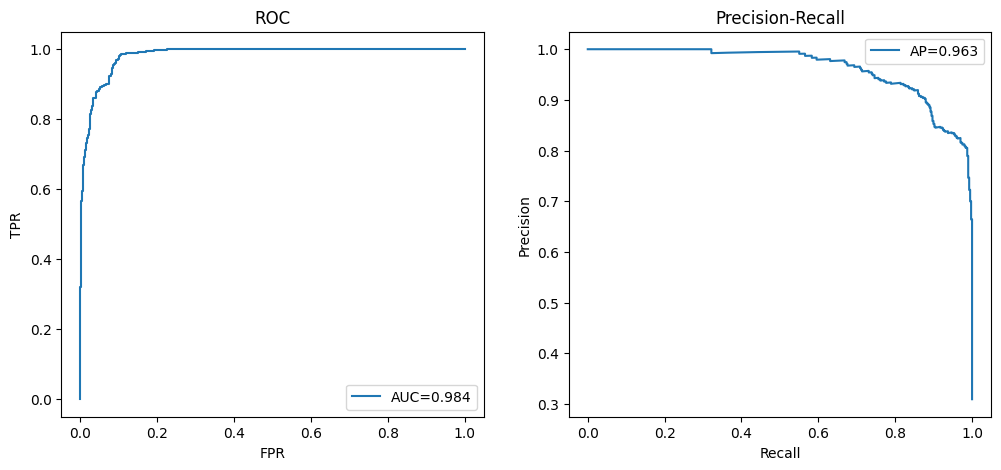


=== EVENT-LEVEL METRICS ===
Event TP: 262 FP: 2 FN: 141
Event Precision: 0.9924 Event Recall: 0.6501 Event F1: 0.7856
Saved event-level JSON -> /content/drive/MyDrive/AccidentProject/eval/event_results.json
Saved human summary -> /content/drive/MyDrive/AccidentProject/eval/eval_summary.txt

Done. CSV and JSON results are in: /content/drive/MyDrive/AccidentProject/eval


In [ ]:
# Evaluation cell: window-level + event-level metrics, save CSV + summary
import numpy as np, os, pandas as pd, math, itertools
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             confusion_matrix, classification_report,
                             precision_recall_fscore_support, roc_curve,
                             precision_recall_curve)
import matplotlib.pyplot as plt
import json
from datetime import timedelta

# --- Params (tweak as needed) ---
THRESHOLD = 0.5            # window-level threshold for binary decisions
EVENT_TOLERANCE = 3.0      # seconds: predicted event matches GT if overlapping within +/- this many seconds
MIN_EVENT_DURATION = 0.5   # seconds: ignore super-short predicted events
SAVE_DIR = os.path.join(PROJECT_DIR, "eval")
os.makedirs(SAVE_DIR, exist_ok=True)

# print the uploaded notebook path (developer-provided file)
NOTEBOOK_PATH = "/mnt/data/accident_tsm_full_notebook_reupload.ipynb"
print("Notebook file (local):", NOTEBOOK_PATH)

# --- Load validation entries ---
if 'tmp_val_idx_file' in globals() and os.path.exists(tmp_val_idx_file):
    val_entries = list(np.load(tmp_val_idx_file, allow_pickle=True))
else:
    entries = list(np.load(index_file, allow_pickle=True))
    # fallback: take last 10% as val
    n_val = max(1, int(len(entries) * 0.1))
    val_entries = entries[:n_val]

print("Validation windows:", len(val_entries))

# --- Helper to load batch windows and predict in reasonable sized batches ---
def predict_on_entries(model, entries, batch_size=64):
    y_true = []
    y_prob = []
    rows = []
    feat_dim_local = np.load(entries[0][0], mmap_mode='r').shape[1]
    for i in range(0, len(entries), batch_size):
        batch = entries[i:i+batch_size]
        X = np.zeros((len(batch), SEQ_LEN, feat_dim_local), dtype=np.float32)
        for j, (feat_path, start_idx, lbl) in enumerate(batch):
            feats = np.load(feat_path, mmap_mode='r')
            clip = feats[int(start_idx): int(start_idx) + SEQ_LEN]
            if clip.shape[0] != SEQ_LEN:
                # pad (shouldn't happen usually)
                pad = np.zeros((SEQ_LEN - clip.shape[0], feats.shape[1]), dtype=np.float32)
                clip = np.concatenate([clip, pad], axis=0)
            X[j] = clip
            y_true.append(int(lbl))
        preds = model.predict(X, verbose=0).ravel()
        y_prob.extend(preds.tolist())
        # store rows for CSV: per-window (video basename, start_frame, center_time, true, prob)
        for k, (feat_path, start_idx, lbl) in enumerate(batch):
            base = os.path.basename(feat_path).replace("-feat.npy", "")
            center_frame = int(start_idx) + SEQ_LEN // 2
            center_time = center_frame / 16.0  # assuming feature fps was 16
            rows.append({
                "video": base,
                "feat_path": feat_path,
                "start_idx": int(start_idx),
                "center_time": center_time,
                "true": int(lbl),
                "prob": float(preds[k])
            })
    return np.array(y_true), np.array(y_prob), pd.DataFrame(rows)

# Run predictions on validation
y_true, y_prob, df_preds = predict_on_entries(model, val_entries, batch_size=64)
print("Predictions done. Examples:\n", df_preds.head())

# --- Window-level metrics ---
auc = roc_auc_score(y_true, y_prob) if y_true.sum() > 0 else float('nan')
ap = average_precision_score(y_true, y_prob) if y_true.sum() > 0 else float('nan')
y_pred = (y_prob >= THRESHOLD).astype(int)

cm = confusion_matrix(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
report = classification_report(y_true, y_pred, zero_division=0)

print("\n=== WINDOW-LEVEL METRICS ===")
print("Window AUC:", auc)
print("Window AP (PR AUC):", ap)
print("Confusion matrix:\n", cm)
print("Precision:", precision, "Recall:", recall, "F1:", f1)
print("\nClassification report:\n", report)

# Save per-window CSV and metrics
csv_path = os.path.join(SAVE_DIR, "window_level_predictions.csv")
df_preds.to_csv(csv_path, index=False)
metrics = {
    "window_auc": float(auc),
    "window_ap": float(ap),
    "precision": float(precision),
    "recall": float(recall),
    "f1": float(f1),
    "threshold": float(THRESHOLD),
    "n_val_windows": int(len(val_entries))
}
with open(os.path.join(SAVE_DIR, "window_metrics.json"), "w") as wf:
    json.dump(metrics, wf, indent=2)
print("Saved CSV ->", csv_path)
print("Saved metrics ->", os.path.join(SAVE_DIR, "window_metrics.json"))

# --- Plot ROC and PR curves (quick) ---
fpr, tpr, _ = roc_curve(y_true, y_prob) if len(np.unique(y_true))>1 else (None, None, None)
precisions, recalls, _ = precision_recall_curve(y_true, y_prob)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
if fpr is not None:
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC")
    plt.legend()
else:
    plt.text(0.2,0.5,"Not enough class variety for ROC")
plt.subplot(1,2,2)
plt.plot(recalls, precisions, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall")
plt.legend()
plt.show()

# === EVENT-LEVEL METRICS ===
# Convert ground-truth windows to per-video event lists (from val_entries -> use underlying txt intervals)
def build_video_intervals_from_index(entries):
    # returns dict: video_basename -> list of (start_sec, end_sec) ground truth intervals
    vid_intervals = {}
    for feat_path, start_idx, lbl in entries:
        base = os.path.basename(feat_path).replace("-feat.npy", "")
        # find raw txt path in DATA_RAW with same base (common extensions)
        txt_path = None
        for ext in ('.txt', '.label'):
            p = os.path.join(DATA_RAW, base + ext)
            if os.path.exists(p):
                txt_path = p; break
        if base not in vid_intervals:
            vid_intervals[base] = set()
        if int(lbl) == 1:
            # the window corresponds to a positive; convert window start/end times
            s_frame = int(start_idx)
            e_frame = int(start_idx) + SEQ_LEN - 1
            s_sec = s_frame / 16.0
            e_sec = e_frame / 16.0
            # store interval with small merge tolerance
            vid_intervals[base].add((round(s_sec,3), round(e_sec,3)))
    # Convert sets -> merged sorted lists
    for k in list(vid_intervals.keys()):
        ints = sorted(list(vid_intervals[k]))
        merged = []
        for a,b in ints:
            if not merged or a > merged[-1][1] + 1e-6:
                merged.append([a,b])
            else:
                merged[-1][1] = max(merged[-1][1], b)
        vid_intervals[k] = [(x[0], x[1]) for x in merged]
    return vid_intervals

# Build predicted events per-video by merging contiguous predicted positive windows
def build_predicted_events(df_preds, threshold=THRESHOLD, tolerance_merge= (SEQ_LEN/16.0)/2.0):
    # tolerance_merge approx half-window so adjacent windows join
    pred_events = {}
    df_pos = df_preds[df_preds['prob'] >= threshold].copy()
    for base, grp in df_pos.groupby('video'):
        times = sorted(grp['center_time'].tolist())
        # merge times into continuous events if centers are within tolerance_merge seconds
        events = []
        for t in times:
            if not events:
                events.append([t - SEQ_LEN/16.0/2.0, t + SEQ_LEN/16.0/2.0])
            else:
                if t <= events[-1][1] + tolerance_merge:
                    # extend
                    events[-1][1] = max(events[-1][1], t + SEQ_LEN/16.0/2.0)
                else:
                    events.append([t - SEQ_LEN/16.0/2.0, t + SEQ_LEN/16.0/2.0])
        # filter tiny events
        filtered = [(max(0, round(a,3)), round(b,3)) for a,b in events if (b - a) >= MIN_EVENT_DURATION]
        pred_events[base] = filtered
    return pred_events

# Ground-truth: parse .txt intervals for each video (full GT intervals)
def load_gt_intervals_for_val(entries):
    gt = {}
    bases = set([os.path.basename(e[0]).replace("-feat.npy","") for e in entries])
    for base in bases:
        # find txt file
        txt_path = None
        for ext in ('.txt', '.label'):
            p = os.path.join(DATA_RAW, base + ext)
            if os.path.exists(p): txt_path = p; break
        intervals = []
        if txt_path:
            for line in open(txt_path,'r'):
                line=line.strip()
                if not line: continue
                if "-" in line:
                    a,b = line.split("-")
                elif "to" in line:
                    a,b = line.split("to")
                else:
                    continue
                try:
                    intervals.append((to_seconds(a), to_seconds(b)))
                except:
                    continue
        gt[base] = intervals
    return gt

gt_intervals = load_gt_intervals_for_val(val_entries)
pred_events = build_predicted_events(df_preds, threshold=THRESHOLD)

# Event-level matching. A predicted event is a true positive if it overlaps any GT interval by > 0 seconds within tolerance
def overlap(a_start,a_end,b_start,b_end):
    return not (a_end < b_start or b_end < a_start)

event_TP = 0; event_FP = 0; event_FN = 0
per_video_matches = {}
for video, gt_list in gt_intervals.items():
    preds = pred_events.get(video, [])
    matched_gt = set()
    for pe in preds:
        p_s,p_e = pe
        matched = False
        for gi_idx, (g_s,g_e) in enumerate(gt_list):
            # consider match if overlap within tolerance or center within +/- EVENT_TOLERANCE
            if overlap(p_s, p_e, g_s - EVENT_TOLERANCE, g_e + EVENT_TOLERANCE):
                matched = True
                matched_gt.add(gi_idx)
                break
        if matched:
            event_TP += 1
        else:
            event_FP += 1
    # ground-truth events that were not matched
    event_FN += max(0, len(gt_list) - len(matched_gt))
    per_video_matches[video] = {"gt": gt_list, "pred": preds, "matched_gt_count": len(matched_gt)}

# compute event-level metrics
ev_precision = event_TP / (event_TP + event_FP) if (event_TP + event_FP)>0 else 0.0
ev_recall = event_TP / (event_TP + event_FN) if (event_TP + event_FN)>0 else 0.0
ev_f1 = 2*ev_precision*ev_recall/(ev_precision+ev_recall) if (ev_precision+ev_recall)>0 else 0.0

print("\n=== EVENT-LEVEL METRICS ===")
print("Event TP:", event_TP, "FP:", event_FP, "FN:", event_FN)
print("Event Precision:", round(ev_precision,4), "Event Recall:", round(ev_recall,4), "Event F1:", round(ev_f1,4))

# Save event-level results and pred_events/gt to JSON
with open(os.path.join(SAVE_DIR, "event_results.json"), "w") as wf:
    json.dump({
        "event_tp": int(event_TP),
        "event_fp": int(event_FP),
        "event_fn": int(event_FN),
        "event_precision": ev_precision,
        "event_recall": ev_recall,
        "event_f1": ev_f1,
        "pred_events": pred_events,
        "gt_intervals": gt_intervals,
        "per_video_matches": per_video_matches
    }, wf, indent=2)

print("Saved event-level JSON ->", os.path.join(SAVE_DIR, "event_results.json"))

# Save a human-readable summary
with open(os.path.join(SAVE_DIR, "eval_summary.txt"), "w") as wf:
    wf.write("=== WINDOW-LEVEL METRICS ===\n")
    wf.write(json.dumps(metrics, indent=2) + "\n\n")
    wf.write("Confusion matrix:\n" + str(cm) + "\n\n")
    wf.write("Classification report:\n" + report + "\n\n")
    wf.write("=== EVENT-LEVEL METRICS ===\n")
    wf.write(f"event_tp: {event_TP}\nevent_fp: {event_FP}\nevent_fn: {event_FN}\nevent_precision: {ev_precision}\nevent_recall: {ev_recall}\nevent_f1: {ev_f1}\n")
print("Saved human summary ->", os.path.join(SAVE_DIR, "eval_summary.txt"))

print("\nDone. CSV and JSON results are in:", SAVE_DIR)
